## Linguistic Case Study

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import boxplot
import itertools
import glob
from scipy import stats
import sys
sys.path.insert(0,'../..')
import g4l.display
from IPython.display import clear_output, display
from g4l.estimators import SMC
from g4l.models import ContextTree
from g4l.estimators.prune import Prune
from g4l.bootstrap.resampling import BlockResampling
from g4l.bootstrap import Bootstrap
from g4l.data import Sample

In [7]:
# global variables 
cache_dir = '../example1/cache'
max_depth = 4

### Loading Brazilian Portuguese (BP) and European Portuguese (EP) samples

In [3]:
X_bp = Sample('../example1/folha.txt', [0, 1, 2, 3, 4])
X_ep = Sample('../example1/publico.txt', [0, 1, 2, 3, 4])

### Estimation of champion trees using the Smallest Maximizer Criterion

In [5]:
# callback function - it prints the latest champion tree estimated by SMC
def fn(ret):
    c, t = ret
    clear_output(wait=True)
    print("c:", c, "\nnum contexts:", t.num_contexts(), "\nlikelihood:", t.log_likelihood())
    
# Instantiates SMC object
smc = SMC(max_depth, penalty_interval=(0, 400), 
          epsilon=0.01)
          #callback_fn= fn)

# Perform estimation for BP sample
smc.fit(X_bp)
print('Done. \n# of champion trees:', len(smc.context_trees))

KeyboardInterrupt: 

### The resulting champion trees

In [5]:
df = pd.DataFrame(columns=['bic_threshold', 'num_contexts', 'log_likelihood', 'tree'])
df['bic_threshold'] = smc.tresholds
df['num_contexts'] = [t.num_contexts() for t in smc.context_trees]
df['log_likelihood'] = [t.log_likelihood() for t in smc.context_trees]
df['tree'] = [t.to_str() for t in smc.context_trees]
df.sort_values(['num_contexts'])
df.head(10)

,bic_threshold,num_contexts,log_likelihood,tree
0,0,149,-76845.386114,0000 0001 0010 0012 0013 0014 0020 0021 0030 0...


### Execute bootstrap to find the optimal tree among all champion trees

In [7]:
num_resamples = 20
datalen = len(X_bp.data)
# Defines the strategy used to generate resamples
resampling_factory = BlockResampling(X_bp, renewal_point='4')

# Instantiates bootstrap object. 
bootstrap = Bootstrap(resampling_factory,
                    '%s/resamples/%s' % (cache_dir, 'bp'),
                    num_resamples,
                    resample_sizes=(datalen  * 0.3, datalen * 0.9),
                    alpha=0.01,
                    num_cores=3)

In [8]:
opt = bootstrap.find_optimal_tree(smc.context_trees)

Calculating likelihood j= 1


/home/arthur/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['node', 'parent_idx']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)
100%|██████████| 20/20 [00:50<00:00,  2.53s/it]

Calculating likelihood j= 2



100%|██████████| 20/20 [00:59<00:00,  2.99s/it]


1

In [9]:
ll_ep = [x.log_likelihood() for x in EP.champion_trees]
num_contexts_ep = [len(x.leaves()) for x in EP.champion_trees]

ll_bp = [x.log_likelihood() for x in BP.champion_trees]
num_contexts_bp = [len(x.leaves()) for x in BP.champion_trees]

NameError: name 'EP' is not defined

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(num_contexts_bp, ll_bp, marker='o', linewidth=1, label="BP")
plt.plot(num_contexts_ep, ll_ep, marker='o', linewidth=1, label="EP")
plt.title("BP/EP Log-likelihood functions")
plt.grid()
plt.legend()
plt.show()

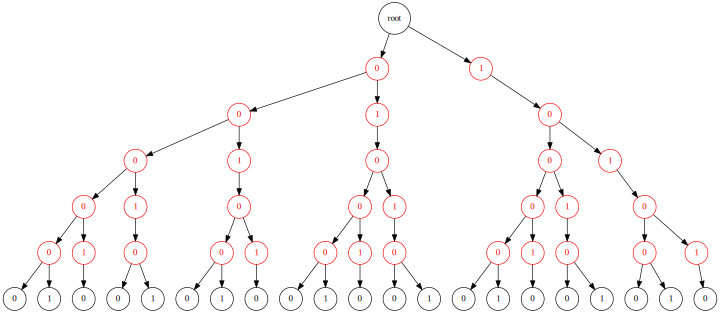

In [27]:
from g4l.models.builders.tree_builder import ContextTreeBuilder
s = '000000 100000 010000 001000 101000 000100 100100 010100 000010 100010 010010 001010 101010 000001 100001 010001 001001 101001 000101 100101 010101'
s = s.split(' ')
b = ContextTreeBuilder(['0', '1'])
[b.add_context(c, [0.5, 0.5]) for c in s]
t = b.build()
g4l.display.draw_tree(t)

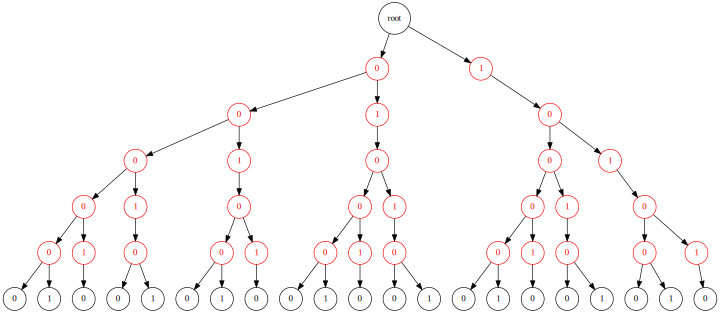

In [31]:
from g4l.models.builders.tree_builder import ContextTreeBuilder
#s = '000000 100000 010000 001000 101000 000100 100100 010100 000010 100010 010010 001010 101010 000001 100001 010001 001001 101001 000101 100101 010101'
#s = '000000 000001 000010 000100 000101 001000 001001 001010 10000 100000 100001 10001 100010 10010 100100 100101 10100 101000 101001 10101 101010'
#s = '000000 000001 000010 000100 000101 001000 001001 001010 010000 010001 010010 010100 010101 100000 100001 100010 100100 100101 101000 101001 101010'
s  = '000000 000001 000010 000100 000101 001000 001001 001010 010000 010001 010010 010100 010101 100000 100001 100010 100100 100101 101000 101001 101010'
s =  '000000 000001 000010 000100 000101 001000 001001 001010 010000 010001 010010 010100 010101 100000 100001 100010 100100 100101 101000 101001 101010'
s = s.split(' ')
b = ContextTreeBuilder(['0', '1'])
[b.add_context(c, [0.5, 0.5]) for c in s]
t = b.build()
g4l.display.draw_tree(t)

In [53]:
fimport scipy.io as sio
from g4l.models import ContextTree
filename = '../example2/samples/model1_5000.mat'
arr = sio.loadmat(filename)['model1_5000']
dt = ''.join([str(x) for x in arr[0]])
sample = Sample(None, [0, 1], data=dt)
ct = ContextTree.init_from_sample(sample, max_depth=6)

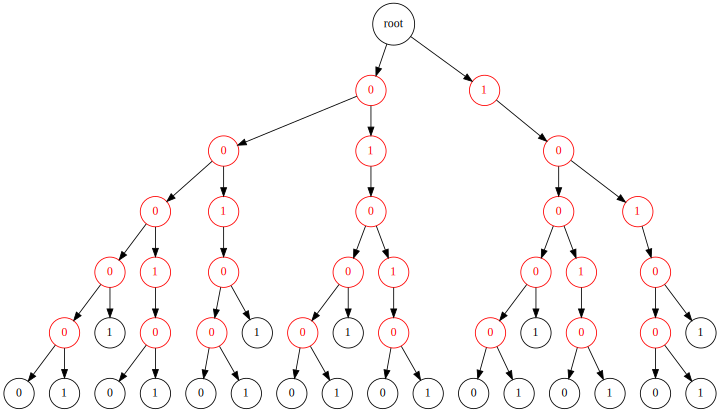

In [67]:
ct.df.loc[ct.df.num_child_nodes.isna(), 'active'] = 1
ct.to_str()
g4l.display.draw_tree(ct)

In [114]:
from g4l.estimators import CTM
ct = ContextTree.init_from_sample(sample, max_depth=6)
#ctm = CTM(100, 6)
ctm._apply_penalization(0, ct.df, sample)
ctm._remove_non_contributive_nodes(ct)
ct.df['remove_node'] = 0
ctm._select_active_contexts(ct.df)
ct.tree()

,node_idx,active,depth,depth_idx,freq,likelihood,lps,node,num_child_nodes,parent_idx,remove_node
1,1,1,1,1,2886,-1675.746574,-1675.746574,0,2.0,None,0
0,0,1,1,0,2114,0.000000,0.000000,1,1.0,None,0


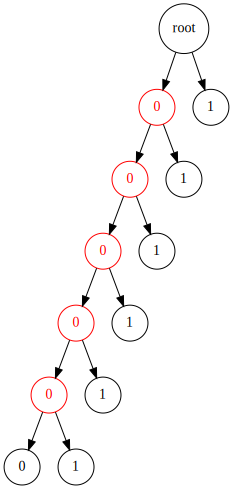

In [94]:
g4l.display.draw_tree(ct)


In [117]:
smc.context_trees[0].to_str()

'0000 0001 0010 0012 0013 0014 0020 0021 0030 0032 0033 0034 0042 0043 0100 0102 0103 0104 0120 0121 0130 0132 0133 0134 0142 0143 0200 0201 0210 0212 0213 0214 0300 0302 0303 0304 0320 0321 0330 0332 0333 0334 0342 0343 0420 0421 0430 0432 0433 1002 1003 1004 1020 1021 1030 1032 1033 1034 1042 1043 1200 1201 1210 1212 1213 1214 1300 1302 1303 1304 1320 1321 1330 1332 1333 1342 1343 1420 1421 1430 1432 1433 2000 2001 2010 2012 2013 2014 2100 2102 2103 2104 2120 2121 2130 2132 2133 2134 2142 2143 3002 3003 3004 3020 3021 3030 3032 3033 3034 3042 3043 3200 3201 3210 3212 3213 3214 3300 3302 3303 3304 3320 3321 3330 3332 3333 3334 3342 3343 3420 3421 3430 3432 3433 4200 4201 4210 4212 4213 4214 4300 4302 4303 4304 4320 4321 4330 4332 4333'

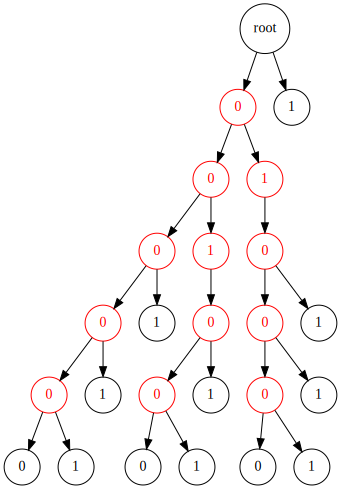

In [15]:
from g4l.models.builders.tree_builder import ContextTreeBuilder
#s = '000000 000010 000100 1 1000 10000 100000 100010 10010 100100 1010 10100'
s = '000000 000010 000100 1 1000 10000 100000 100010 10010 100100 1010 10100'
#s = '000000 000010 000100 01010 1 1000 10000 100000 100010 10010 100100 10100'
#s = '000000 000001 000010 000100 000101 001000 001001 001010 10000 100000 100001 10001 100010 10010 100100 100101 10100 101000 101001 10101 101010'
s = s.split(' ')
b = ContextTreeBuilder(['0', '1'])
[b.add_context(c, [0.5, 0.5]) for c in s]
t = b.build()
g4l.display.draw_tree(t)

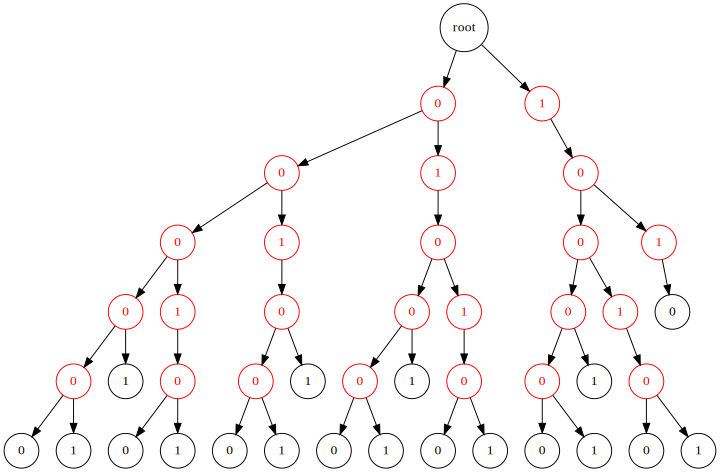

In [4]:
from g4l.models.builders.tree_builder import ContextTreeBuilder
s = '000000 000001 000010 000100 001000 001001 00101 001010 10000 100000 100001 10001 100010 10010 100100 10100 101000 101001 10101 101010'
s = '000000 000001 000010 000100 001000 001001 001010 0101 10000 100000 100001 10001 100010 10010 100100 10100 101000 101001 101010'
#s = '000000 000001 000010 000100 001000 001001 001010 0101 10000 100000 100001 10001 100010 10010 100100 10100 101000 101001 101010'
#s = '000000 000001 000010 000100 001000 001001 001010 10000 100000 100001 10001 100010 10010 100100 101 10100 101000 101001 101010'

s = s.split(' ')
b = ContextTreeBuilder(['0', '1'])
[b.add_context(c, [0.5, 0.5]) for c in s]
t = b.build()
g4l.display.draw_tree(t)

In [22]:
filename = "/home/arthur/Documents/Neuromat/projects/SMC/arquivo/data/model1_20000.csv"

f_5k = [x.replace(',', '') for x in open(filename).read().split('\n')]
X = Sample(None, [0, 1], data=f_5k[0])
#initial_tree = ContextTree.init_from_sample(X, max_depth=6)
p = Prune(6).fit(X)

In [23]:
prune_results = np.array([[t.num_contexts(), t.log_likelihood(), t.to_str()] for t in p.context_trees]).T
# Tree generation summary for pruning method
prune_summary = pd.DataFrame(prune_results.T, columns=['num_contexts', 'log-likelihood', 'tree'])
prune_summary['num_contexts'] = prune_summary['num_contexts'].astype(int)
prune_summary = prune_summary.sort_values(['num_contexts'])
prune_summary


,num_contexts,log-likelihood,tree
19,2,-6787.113926324419,0 1
18,3,-6725.239226702288,00 1 10
17,4,-6713.872653821701,000 1 10 100
16,5,-6713.402630214673,0000 1 10 100 1000
15,6,-6713.359248375161,00000 1 10 100 1000 10000
14,7,-6712.1063902325795,000000 1 10 100 1000 10000 100000
13,8,-6712.10332290503,000000 0010 1 100 1000 10000 100000 1010
12,9,-6712.062434888722,000000 00010 1 100 1000 10000 100000 10010 1010
11,10,-6711.375472225333,000000 000010 1 100 1000 10000 100000 100010 1...
10,11,-6711.3622754105245,000000 000010 00100 1 1000 10000 100000 100010...


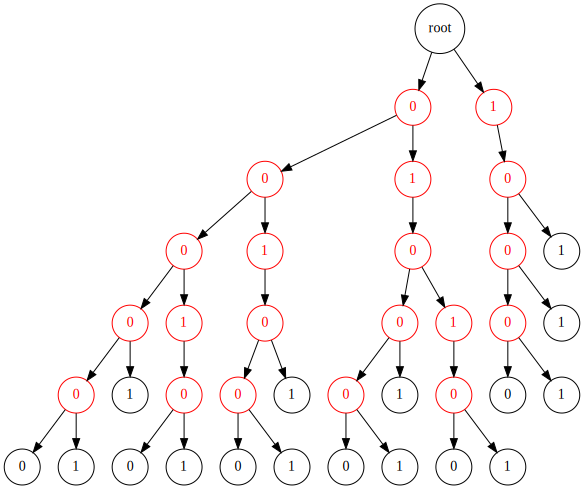

In [24]:
g4l.display.draw_tree(p.context_trees[4])